In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/beamforming-data-analysis/beamforming_dataset.csv


# Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

2025-07-24 20:29:39.200785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753388979.459221      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753388979.530877      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Data Loading

In [3]:
df = pd.read_csv('/kaggle/input/beamforming-data-analysis/beamforming_dataset.csv')

In [4]:
df.head()

,sample_id,user_loc_hist_x_0,user_loc_hist_y_0,user_loc_hist_x_1,user_loc_hist_y_1,user_loc_hist_x_2,user_loc_hist_y_2,user_loc_hist_x_3,user_loc_hist_y_3,user_loc_hist_x_4,...,csi_beam_5,csi_beam_6,csi_beam_7,beam_hist_0,beam_hist_1,beam_hist_2,beam_hist_3,beam_hist_4,sinr,optimal_beam_index
0,0,51.857691,16.431856,62.919147,-26.694539,-94.865295,-1.516257,-17.190054,-95.728383,33.980550,...,2.964829,5.932241,6.349953,4,1,2,2,6,6.369092,2
1,1,-37.225273,-16.337037,-53.455520,-94.147930,43.411029,98.100884,7.226816,-29.459182,70.369568,...,2.459980,6.943596,3.087622,0,4,0,0,2,12.462178,1
2,2,77.031690,3.970814,-46.483865,-28.278262,87.036809,-12.240793,-65.956373,0.682597,21.902704,...,3.444585,1.728221,6.249143,2,5,0,0,1,26.177661,2
3,3,-17.785836,4.961503,-49.034502,-38.873527,99.192286,-19.290668,28.382459,-83.847260,88.615291,...,1.277260,2.789594,8.394630,7,3,6,7,0,16.474037,7
4,4,20.725721,6.003185,54.122171,92.838712,26.094274,99.988461,89.469675,26.114648,-55.987237,...,6.461580,7.412339,8.544736,1,6,1,3,3,19.418128,1


Here in the data we have different features:

1. num_samples: Total number of data points (e.g., 10,000 different time instances/scenarios).

2. num_beams: Number of discrete beam directions available (e.g., 8).

3. history_length: How many past time steps we consider for user location and beamforming history.

4. User Location History (user_loc_hist_x_i, user_loc_hist_y_i): Simulated as 2D (x, y) coordinates. history_length pairs of (x, y) values for each sample, representing the path the user took.

5. Channel State Information (CSI) (csi_beam_i):
- Simplified as num_beams individual values. Each value represents the "strength" or "gain" of the channel if that particular beam were used.
- Higher values generally imply better channel conditions for that beam.
- In reality, CSI is a complex matrix or vector of channel impulse responses, often involving complex numbers. This simplified version is for demonstration.

6. Beamforming History (beam_hist_i):

- history_length integer values, each representing the index of the beam that was used at a previous time step.

- Values are np.random.randint from 0 to num_beams-1.

7. SINR (sinr):

- A single floating-point value representing the Signal-to-Interference-plus-Noise Ratio.

- Simulated as np.random.uniform within a typical dB range.

8. Optimal Beam Index (optimal_beam_index):

- This is our target variable. For this synthetic dataset, we've implemented a very simplistic rule:

- It primarily picks the beam with the highest current CSI gain.

- It includes a small, arbitrary "location bias" (e.g., if the user's last X coordinate is high, it might slightly shift the optimal beam index). This rule is crucial: In a real-world scenario, this value would be derived from actual network optimization, measurements, or a more sophisticated simulator. Your ML model will learn to approximate this complex underlying function.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sample_id           10000 non-null  int64  
 1   user_loc_hist_x_0   10000 non-null  float64
 2   user_loc_hist_y_0   10000 non-null  float64
 3   user_loc_hist_x_1   10000 non-null  float64
 4   user_loc_hist_y_1   10000 non-null  float64
 5   user_loc_hist_x_2   10000 non-null  float64
 6   user_loc_hist_y_2   10000 non-null  float64
 7   user_loc_hist_x_3   10000 non-null  float64
 8   user_loc_hist_y_3   10000 non-null  float64
 9   user_loc_hist_x_4   10000 non-null  float64
 10  user_loc_hist_y_4   10000 non-null  float64
 11  csi_beam_0          10000 non-null  float64
 12  csi_beam_1          10000 non-null  float64
 13  csi_beam_2          10000 non-null  float64
 14  csi_beam_3          10000 non-null  float64
 15  csi_beam_4          10000 non-null  float64
 16  csi_b

In [6]:
df.describe()

,sample_id,user_loc_hist_x_0,user_loc_hist_y_0,user_loc_hist_x_1,user_loc_hist_y_1,user_loc_hist_x_2,user_loc_hist_y_2,user_loc_hist_x_3,user_loc_hist_y_3,user_loc_hist_x_4,...,csi_beam_5,csi_beam_6,csi_beam_7,beam_hist_0,beam_hist_1,beam_hist_2,beam_hist_3,beam_hist_4,sinr,optimal_beam_index
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.325104,-0.302147,-0.016580,0.620732,0.929860,0.627001,-0.236695,-1.035627,-1.247463,...,5.075503,5.036890,5.038112,3.50690,3.50220,3.493600,3.508700,3.491500,17.421383,3.616000
std,2886.89568,58.191010,57.530205,57.303778,57.772163,57.707768,57.587878,57.382690,57.714308,57.524857,...,2.880924,2.871532,2.847330,2.29305,2.28397,2.276769,2.293829,2.290776,7.196477,2.282688
min,0.00000,-99.947542,-99.998059,-99.992984,-99.996790,-99.986027,-99.993389,-99.968288,-99.999993,-99.954957,...,0.100200,0.100046,0.100335,0.00000,0.00000,0.000000,0.000000,0.000000,5.003507,0.000000
25%,2499.75000,-50.677117,-50.190089,-48.674077,-49.725459,-48.912149,-49.190754,-49.287389,-51.424974,-51.360085,...,2.586787,2.504898,2.573640,2.00000,2.00000,2.000000,2.000000,1.000000,11.136612,2.000000
50%,4999.50000,0.320167,0.200420,-0.259913,0.875761,1.350589,0.912906,0.384411,-2.171292,-1.677622,...,5.098972,5.059064,5.026271,3.00000,4.00000,3.000000,4.000000,4.000000,17.356167,4.000000
75%,7499.25000,50.938478,49.278699,48.660853,50.601777,50.775882,50.152045,48.653145,49.016479,48.414975,...,7.564823,7.537030,7.520178,6.00000,5.00000,5.000000,6.000000,5.000000,23.575427,6.000000
max,9999.00000,99.964268,99.983350,99.971405,99.922727,99.988871,99.988461,99.990378,99.999262,99.996028,...,9.999913,9.998839,9.996120,7.00000,7.00000,7.000000,7.000000,7.000000,29.997548,7.000000


In [7]:
df.isnull().sum()

sample_id             0
user_loc_hist_x_0     0
user_loc_hist_y_0     0
user_loc_hist_x_1     0
user_loc_hist_y_1     0
user_loc_hist_x_2     0
user_loc_hist_y_2     0
user_loc_hist_x_3     0
user_loc_hist_y_3     0
user_loc_hist_x_4     0
user_loc_hist_y_4     0
csi_beam_0            0
csi_beam_1            0
csi_beam_2            0
csi_beam_3            0
csi_beam_4            0
csi_beam_5            0
csi_beam_6            0
csi_beam_7            0
beam_hist_0           0
beam_hist_1           0
beam_hist_2           0
beam_hist_3           0
beam_hist_4           0
sinr                  0
optimal_beam_index    0
dtype: int64

# EDA

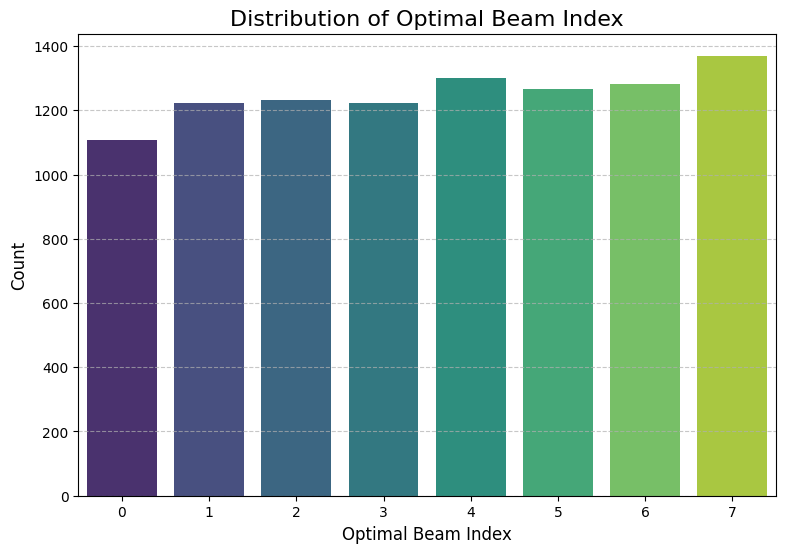

Observation: Check if the optimal beam indices are evenly distributed or if some beams are preferred. Imbalance might require special handling (e.g., oversampling, undersampling) during model training.


In [8]:
# 1.1 Distribution of Optimal Beam Index (Target Variable)
# This is crucial for classification tasks to check for class imbalance.
dataset = df.copy()
plt.figure(figsize=(9, 6))
sns.countplot(x='optimal_beam_index', data=dataset, palette='viridis')
plt.title('Distribution of Optimal Beam Index', fontsize=16)
plt.xlabel('Optimal Beam Index', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
print("Observation: Check if the optimal beam indices are evenly distributed or if some beams are preferred. Imbalance might require special handling (e.g., oversampling, undersampling) during model training.")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


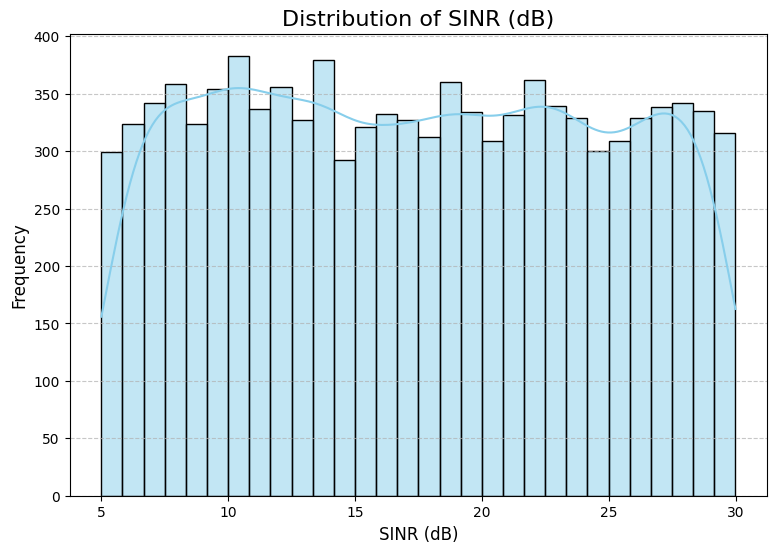

Observation: Understand the range and typical values of SINR. Is it concentrated, or spread out? This reflects the varying channel conditions.


In [9]:
# 1.2 Distribution of SINR (Signal-to-Interference-plus-Noise Ratio)
plt.figure(figsize=(9, 6))
sns.histplot(dataset['sinr'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of SINR (dB)', fontsize=16)
plt.xlabel('SINR (dB)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
print("Observation: Understand the range and typical values of SINR. Is it concentrated, or spread out? This reflects the varying channel conditions.")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

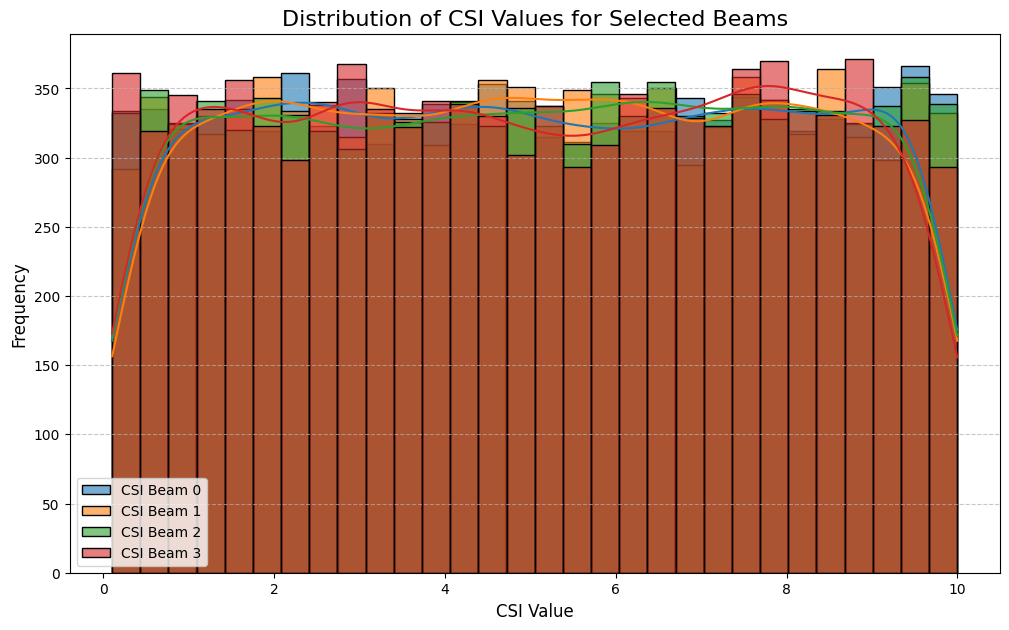

Observation: Check if CSI values for different beams have similar or distinct distributions. This can indicate if some beams inherently have better channel conditions.


In [10]:
# 1.3 Distribution of CSI values for a few beams
# CSI values are crucial inputs. Let's look at a few of them.
NUM_BEAMS = len(dataset['optimal_beam_index'].unique())

plt.figure(figsize=(12, 7))
for i in range(min(4, NUM_BEAMS)): # Plot for first 4 CSI beams
    sns.histplot(dataset[f'csi_beam_{i}'], bins=30, kde=True, label=f'CSI Beam {i}', alpha=0.6, edgecolor='black')
plt.title('Distribution of CSI Values for Selected Beams', fontsize=16)
plt.xlabel('CSI Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
print("Observation: Check if CSI values for different beams have similar or distinct distributions. This can indicate if some beams inherently have better channel conditions.")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


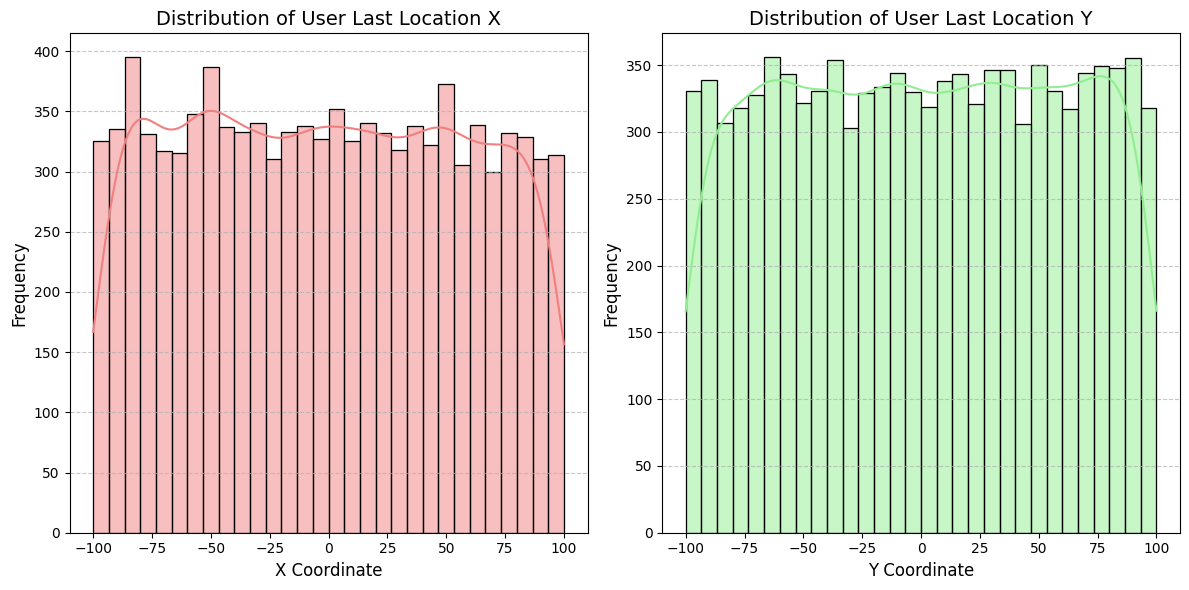

Observation: These plots show the spatial distribution of user positions. Are users concentrated in certain areas or spread out?


In [11]:
# 1.4 Distribution of User Location History (e.g., last point)
HISTORY_LENGTH = sum('user_loc_hist_x_' in col for col in dataset.columns)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(dataset[f'user_loc_hist_x_{HISTORY_LENGTH-1}'], bins=30, kde=True, color='lightcoral', edgecolor='black')
plt.title(f'Distribution of User Last Location X', fontsize=14)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.histplot(dataset[f'user_loc_hist_y_{HISTORY_LENGTH-1}'], bins=30, kde=True, color='lightgreen', edgecolor='black')
plt.title(f'Distribution of User Last Location Y', fontsize=14)
plt.xlabel('Y Coordinate', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Observation: These plots show the spatial distribution of user positions. Are users concentrated in certain areas or spread out?")


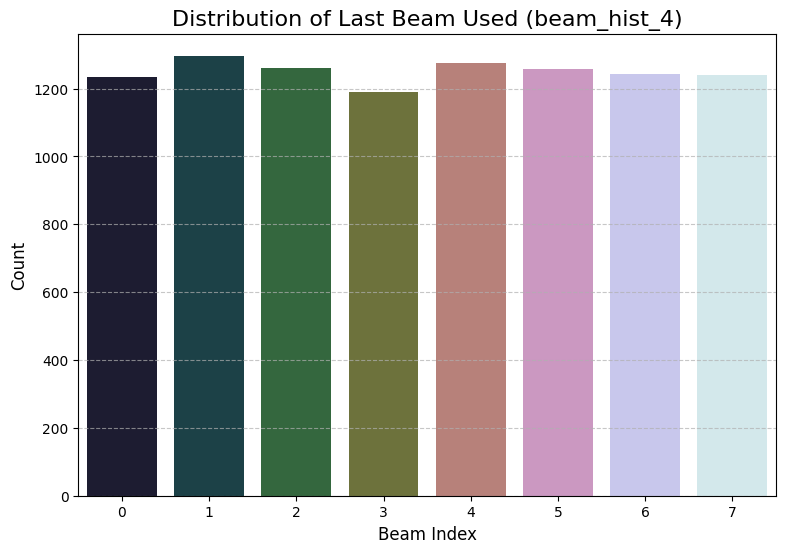

Observation: Similar to optimal beam, this shows the distribution of previously selected beams. Is there a bias towards certain beams?


In [12]:
# 1.5 Distribution of Beamforming History (e.g., last point)
plt.figure(figsize=(9, 6))
sns.countplot(x=f'beam_hist_{HISTORY_LENGTH-1}', data=dataset, palette='cubehelix')
plt.title(f'Distribution of Last Beam Used (beam_hist_{HISTORY_LENGTH-1})', fontsize=16)
plt.xlabel('Beam Index', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
print("Observation: Similar to optimal beam, this shows the distribution of previously selected beams. Is there a bias towards certain beams?")


## # --- 2. Bivariate Analysis ---
# Understanding relationships between features and with the target variable

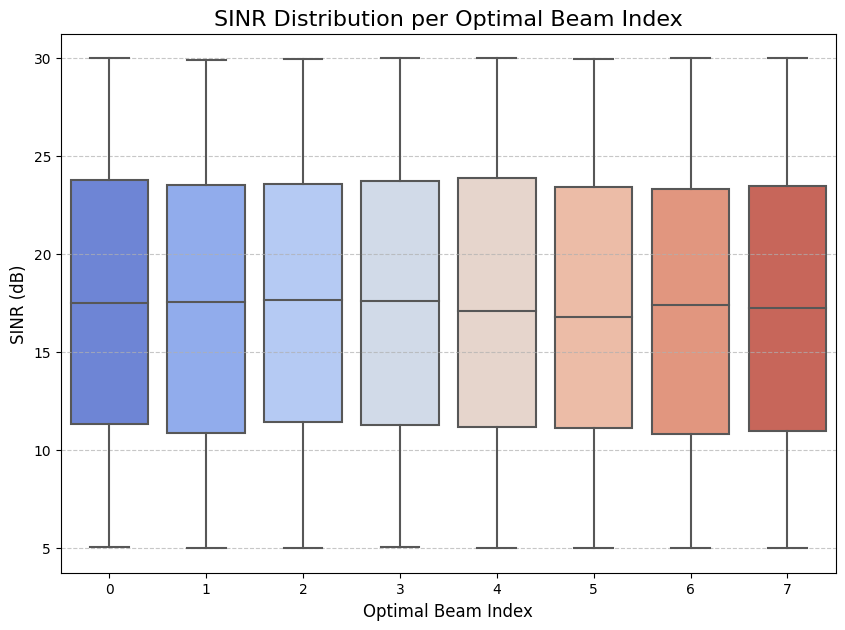

Observation: This plot can reveal if certain optimal beams are associated with higher or lower SINR values. A clear separation might indicate strong predictive power.


In [13]:
# 2.1 SINR vs. Optimal Beam Index (Box Plot)
# How does SINR vary for different optimal beams?
plt.figure(figsize=(10, 7))
sns.boxplot(x='optimal_beam_index', y='sinr', data=dataset, palette='coolwarm')
plt.title('SINR Distribution per Optimal Beam Index', fontsize=16)
plt.xlabel('Optimal Beam Index', fontsize=12)
plt.ylabel('SINR (dB)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
print("Observation: This plot can reveal if certain optimal beams are associated with higher or lower SINR values. A clear separation might indicate strong predictive power.")


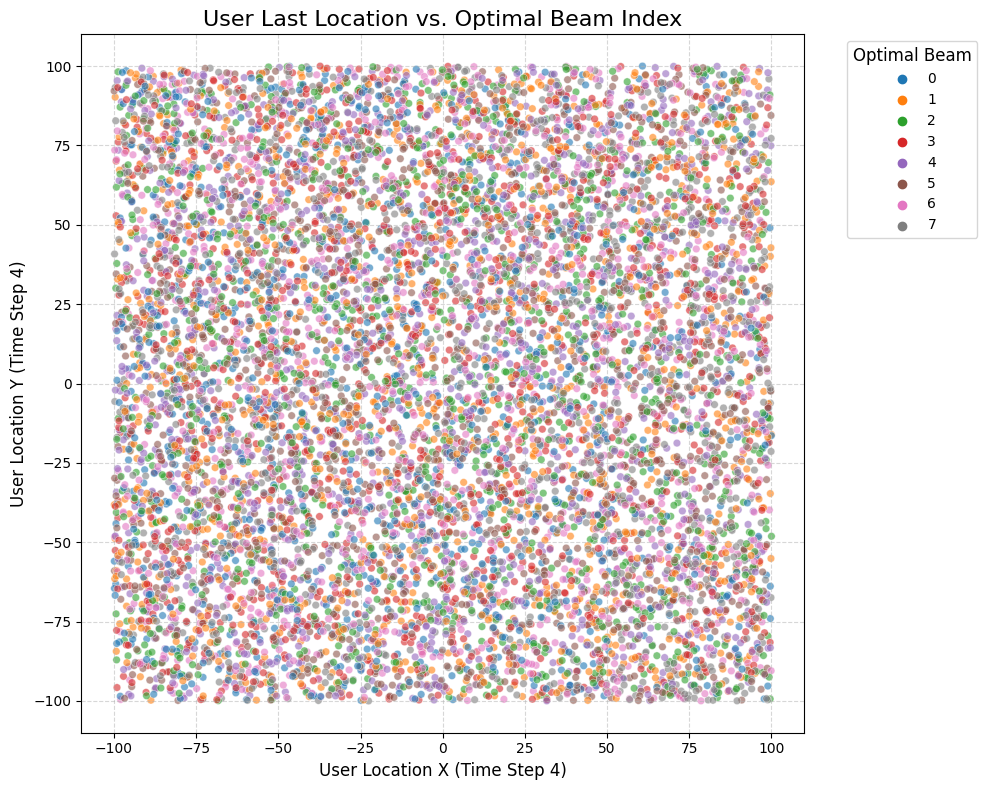

Observation: Look for clusters or regions where specific optimal beams are predominantly chosen. This indicates the spatial influence on beam selection.


In [14]:
# 2.2 User Last Location (Scatter Plot) colored by Optimal Beam Index
plt.figure(figsize=(10, 8))
sns.scatterplot(x=f'user_loc_hist_x_{HISTORY_LENGTH-1}', y=f'user_loc_hist_y_{HISTORY_LENGTH-1}',
                hue='optimal_beam_index', data=dataset, palette='tab10', alpha=0.6, s=30)
plt.title(f'User Last Location vs. Optimal Beam Index', fontsize=16)
plt.xlabel(f'User Location X (Time Step {HISTORY_LENGTH-1})', fontsize=12)
plt.ylabel(f'User Location Y (Time Step {HISTORY_LENGTH-1})', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Optimal Beam', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()
print("Observation: Look for clusters or regions where specific optimal beams are predominantly chosen. This indicates the spatial influence on beam selection.")


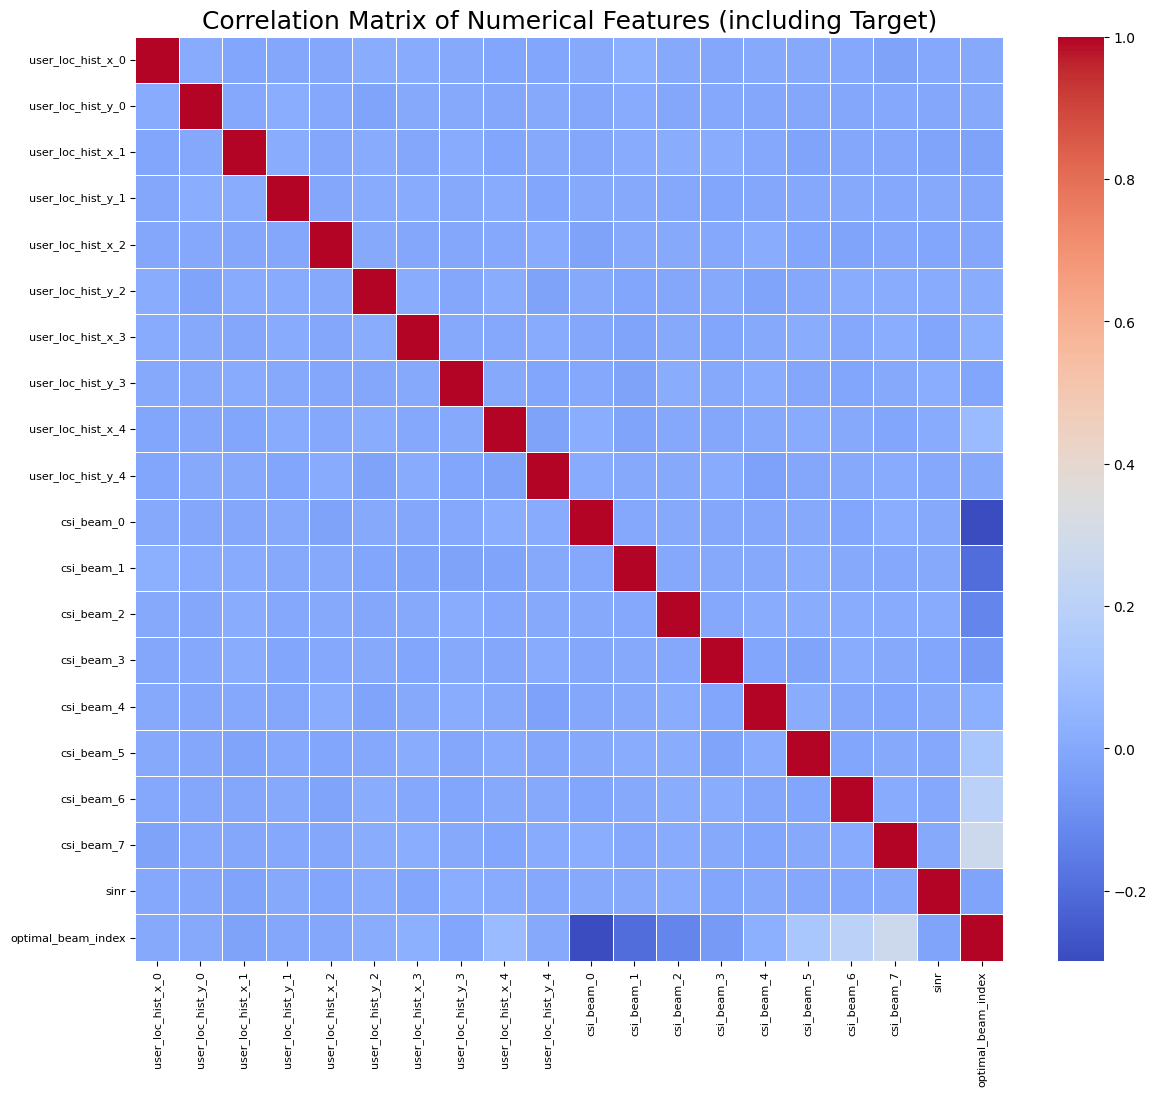

Observation: High positive or negative correlations indicate strong linear relationships. Pay attention to correlations with 'optimal_beam_index' to identify potentially important features. Note that 'optimal_beam_index' is categorical, so its correlation with continuous features should be interpreted with care (e.g., it might show a trend, but not a strict linear relationship).


In [15]:
# 2.3 Correlation Matrix (Numerical Features)
# Exclude 'sample_id' and 'beam_hist' features from correlation as they are discrete/identifiers.
# Include optimal_beam_index to see its correlation with other numerical features.
numerical_cols_for_corr = [col for col in dataset.columns if 'user_loc_hist' in col or 'csi_beam' in col or 'sinr' in col or 'optimal_beam_index' in col]

plt.figure(figsize=(14, 12))
correlation_matrix = dataset[numerical_cols_for_corr].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features (including Target)', fontsize=18)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8, rotation=0)
plt.show()
print("Observation: High positive or negative correlations indicate strong linear relationships. Pay attention to correlations with 'optimal_beam_index' to identify potentially important features. Note that 'optimal_beam_index' is categorical, so its correlation with continuous features should be interpreted with care (e.g., it might show a trend, but not a strict linear relationship).")


# Feature Engineering

- Feature Scaling and Normalization
- ENcoding categorical features
- Structuring inputs for DL

# Model Selection and Training

For this task we can use different models.

- Supervised learning: This is a multi-class classification problem where you predict one of num_beams classes.
- Deep Learning+ Embeddings. It is for the high- dimensional CSI/ History

    - Autoencoders to reduce the dimensionality or learning compressed representations of high- dimensional embedding, then use this embedding as an input to the main classification model
    - KNN - For similarity matching. For defining distance metric between samples. KNN Directly classifies based on the majority class of its nearest neighbors in the feature space.

# Results

# Conclusion